# **How do you win at league of legends?**  
I play a lot of video games and wanted to do some form of data analysis in the same field. League of Legends is a competitive game, an esport, it is the most popular esport in the world. The 2017 finals was watched by 46 million unique viewers. It is considered a legitimate sport by the US government. A lot of the professional teams are backed or owned by NBA temas. In short League of legends has become very popular and very professioonal. Riot games has recently started hiring a lot of data analysts, so figured why not kill two birds with one stone and do this in conjunction with somthing i enjoy.


* My goal was to analyze data from ranked matched to determine what factors had the biggest impact on winning the game.
* I spent a lot of time plotting information in various was and cleaning up the data.
* There was a lot of backtrack figuring out what was relevant and what should be thrown out
* League is an ever changing game with constant updates and balancing patches every 1 to 2 weeks.
* Each season there are major changes, big enough that I threw out season 1-7.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')

In [3]:
# A list of all the champions 
champs = pd.read_csv('../input/champs.csv')
#match ID is really the only thing relevant here so we can sync up players 10 to a game
matches = pd.read_csv('../input/matches.csv')
#this is the actual players, 10 to a match ID
participants = pd.read_csv('../input/participants.csv')
#these are the the stats for the participents both are ezactly the same in terms of columns 
stats1 = pd.read_csv('../input/stats1.csv')
stats2 = pd.read_csv('../input/stats2.csv')

stats = stats1.append(stats2)
stats.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1834517, 56)

In [6]:
#merge our data 
df = pd.merge(participants, stats, how = 'left', on = ['id'], suffixes=('', '_y'))
df = pd.merge(df, champs, how = 'left', left_on = 'championid', right_on = 'id', suffixes=('', '_y'))
df = pd.merge(df, matches, how = 'left', left_on = 'matchid', right_on = 'id', suffixes=('', '_y'))

#The data is set up weird with role and position basicaly being the same thing but each
# one differentiate different. for top and mid in role both are labeled as solo
#in position for duo-support/duo_carry both are listed as bot 
def final_position(row):
    if row['role'] in ('DUO_SUPPORT', 'DUO_CARRY'):
        return row['role']
    else:
        return row['position']
#apply the fix to make it easy to differentiate between roles
df['adjposition'] = df.apply(final_position, axis = 1) 

#differentiate between teams
df['team'] = df['player'].apply(lambda x: '1' if x <= 5 else '2')
df['team_role'] = df['team'] + ' - ' + df['adjposition']

# remove matchid with duplicate roles, e.g. 3 MID in same team, etc
remove_index = []
for i in ('1 - MID', '1 - TOP', '1 - DUO_SUPPORT', '1 - DUO_CARRY', '1 - JUNGLE', '2 - MID', '2 - TOP', '2 - DUO_SUPPORT', '2 - DUO_CARRY', '2 - JUNGLE'):
    df_remove = df[df['team_role'] == i].groupby('matchid').agg({'team_role':'count'})
    remove_index.extend(df_remove[df_remove['team_role']!=1].index.values)
    
# remove unclassified BOT
# remove previous season they are not relevant to getting better this season
remove_index.extend(df[df['adjposition'] == 'BOT']['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 7]['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 6]['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 5]['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 4]['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 3]['matchid'].unique())
remove_index.extend(df[df['seasonid'] == 2]['matchid'].unique())
remove_index = list(set(remove_index))

#here we actualy remove all the junk from above
print('# matches in dataset before cleaning: {}'.format(df['matchid'].nunique()))
df = df[~df['matchid'].isin(remove_index)]
print('# matches in dataset after cleaning: {}'.format(df['matchid'].nunique()))

# matches in dataset before cleaning: 184069
# matches in dataset after cleaning: 140403


We removed a decent chunk of data, but most recorded matches were from this season so we still have a good number of matches to analyze

In [7]:
#narrow down the the columns to just the relevant data. e.g. we really dont care about items, thats pretty dependant on champion we are looking for over all win rate
df = df[['id', 'matchid', 'player', 'name', 'adjposition', 'team_role', 'win', 'kills', 'deaths', 'assists', 'ownjunglekills', 'enemyjunglekills', 'pentakills' , 'turretkills','totdmgtochamp',  'visionscore' , 'totminionskilled', 'goldspent', 'totdmgtaken', 'inhibkills', 'pinksbought', 'wardsplaced', 'firstblood' ,'duration', 'platformid', 'seasonid', 'version']]
df.head(10)

,id,matchid,player,name,adjposition,team_role,win,kills,deaths,assists,...,goldspent,totdmgtaken,inhibkills,pinksbought,wardsplaced,firstblood,duration,platformid,seasonid,version
0,9,10,1,Warwick,JUNGLE,1 - JUNGLE,0.0,6.0,10.0,1.0,...,10275.0,41446.0,0.0,0.0,10.0,0.0,1909,EUW1,8,7.10.187.9675
1,10,10,2,Nami,DUO_SUPPORT,1 - DUO_SUPPORT,0.0,0.0,2.0,12.0,...,7975.0,17769.0,0.0,1.0,17.0,0.0,1909,EUW1,8,7.10.187.9675
2,11,10,3,Draven,DUO_CARRY,1 - DUO_CARRY,0.0,7.0,8.0,5.0,...,11775.0,25627.0,0.0,1.0,13.0,0.0,1909,EUW1,8,7.10.187.9675
3,12,10,4,Fiora,TOP,1 - TOP,0.0,5.0,11.0,2.0,...,10683.0,31705.0,0.0,0.0,3.0,0.0,1909,EUW1,8,7.10.187.9675
4,13,10,5,Viktor,MID,1 - MID,0.0,2.0,8.0,2.0,...,10485.0,20585.0,0.0,0.0,10.0,0.0,1909,EUW1,8,7.10.187.9675
5,14,10,6,Skarner,JUNGLE,2 - JUNGLE,1.0,3.0,3.0,9.0,...,11758.0,22708.0,0.0,0.0,8.0,0.0,1909,EUW1,8,7.10.187.9675
6,15,10,7,Galio,TOP,2 - TOP,1.0,4.0,5.0,11.0,...,11575.0,21719.0,0.0,1.0,7.0,0.0,1909,EUW1,8,7.10.187.9675
7,16,10,8,Ahri,MID,2 - MID,1.0,13.0,4.0,8.0,...,13750.0,19174.0,0.0,0.0,8.0,0.0,1909,EUW1,8,7.10.187.9675
8,17,10,9,Jinx,DUO_CARRY,2 - DUO_CARRY,1.0,15.0,3.0,9.0,...,14375.0,17655.0,2.0,1.0,6.0,1.0,1909,EUW1,8,7.10.187.9675
9,18,10,10,VelKoz,DUO_SUPPORT,2 - DUO_SUPPORT,1.0,4.0,5.0,19.0,...,11675.0,13443.0,0.0,5.0,25.0,0.0,1909,EUW1,8,7.10.187.9675


The first 10 lets us see a sample of stats all from the same game

Lets see how things corralate without any data manipulation

Text(0.5,1,'What are the biggest factors in winning')

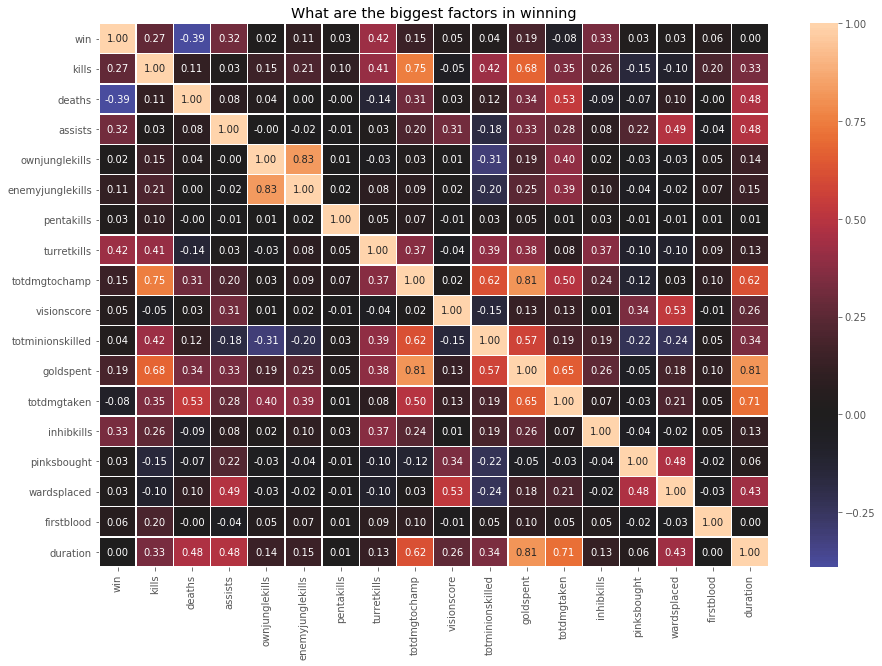

In [15]:
df_corr = df._get_numeric_data()
df_corr = df_corr.drop(['id', 'matchid', 'player', 'seasonid'], axis = 1)

plt.figure(figsize = (15,10))
sns.heatmap(df_corr.corr(),  annot = True, fmt = '.2f',  linewidths=.5, center = 0)
plt.title('What are the biggest factors in winning')

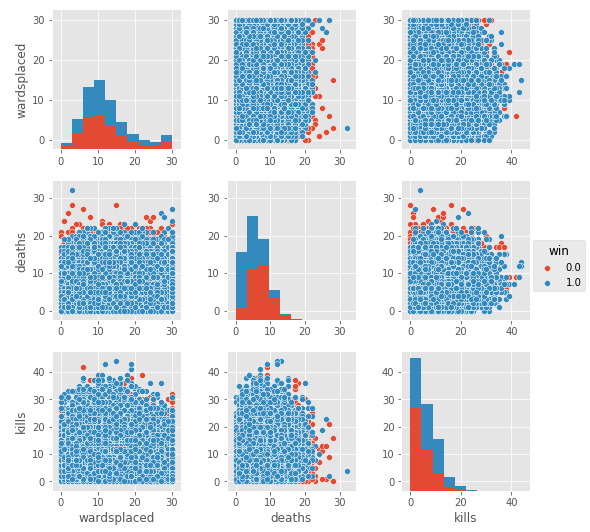

In [9]:
#make a copy because I dont actualy want to manipulate the main data set at the moment
df_v = df.copy()
# put upper and lower limit there were some crazy outliers that made the graph unreadable
df_v['wardsplaced'] = df_v['wardsplaced'].apply(lambda x: x if x<30 else 30)
df_v['wardsplaced'] = df_v['wardsplaced'].apply(lambda x: x if x>0 else 0)
#ended up not using this one
df_v['pinksbought'] = df_v['pinksbought'].apply(lambda x: x if x<10 else 10)
df_v['pinksbought'] = df_v['pinksbought'].apply(lambda x: x if x>0 else 0)

plt.figure(figsize = (15,10))
sns.pairplot(df_v, hue="win", vars=['wardsplaced', 'deaths', 'kills'])


It does seem like there might be somthing to the winning side placing more wards and getting more kills.
Kills do seems to correlate to a win as well, Lets explore thie a little.

In [68]:
df2= df[['win', 'kills', 'wardsplaced', 'deaths']]

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
# nan nan nan nan nan
#got get rid of missing data and nans
from sklearn.preprocessing import Imputer
my_imputer = Imputer()
kills2 = my_imputer.fit_transform(df2[['kills']])
df2['kills'] = kills2
WP = my_imputer.fit_transform(df2[['wardsplaced']])
df2['wardsplaced'] = WP
DT = my_imputer.fit_transform(df2[['deaths']])
df2['deaths'] = DT
WI = my_imputer.fit_transform(df2[['win']])
df2['win'] = WI
#1.0 0.0 unknowk label type conituos because I dont like floats
df2['win'] = df2['win'].astype(int)


In [71]:
X = df2[['wardsplaced', 'deaths', 'kills']]
y = df2['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

Create and train the model

In [72]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
predictions = logmodel.predict(X_test)

Evalute the model

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74    232379
          1       0.74      0.74      0.74    230945

avg / total       0.74      0.74      0.74    463324



It seems like that is an ok indication of wins
Create a functioon to streamline the process instead of constantly updating the previous section

In [79]:
def logRegModel(X, y):

    # Split the data (X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

    # Create and train model
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    predictions = logmodel.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))

In [81]:
df3 = df[['win', 'turretkills', 'inhibkills' ]]
TR = my_imputer.fit_transform(df3[['turretkills']])
df3['turretkills'] = TR
IH = my_imputer.fit_transform(df3[['inhibkills']])
df3['inhibkills'] = TR
WI = my_imputer.fit_transform(df3[['win']])
df3['win'] = WI
df3['win'] = df3['win'].astype(int)

In [82]:
X = df3[['turretkills', 'inhibkills']]
y = df3['win']
logRegModel(X, y)

             precision    recall  f1-score   support

          0       0.71      0.70      0.70    232379
          1       0.70      0.71      0.70    230945

avg / total       0.70      0.70      0.70    463324



This is supprising because in order to win you have to kill at least 5 towers and 1 inhib. Usualy when I win games we have somthing like 9-11 towers and 3+ inhib kils

In [88]:
df4= df[['win', 'pentakills']]
PK = my_imputer.fit_transform(df4[['pentakills']])
df4['pentakills'] = PK
df4['pentakills'] = df4['pentakills'].astype(int)
df4['win'] = WI
df4['win'] = df4['win'].astype(int)

In [89]:
X = df4[['pentakills']]
y = df4['win']
logRegModel(X, y)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00    232379
          1       0.50      1.00      0.67    230945

avg / total       0.25      0.50      0.33    463324



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This is also very supprising. A penta kill is when one person kills the entire enemy team on their own, you would think if 1 person is capable of that it would be a guaranteed win. With such a small sample size it is hard to say if this is true or not. lets lookk at game that only have penta kills.

In [91]:
df5 = df4.loc[df4['pentakills'] != 0]

In [92]:
X = df5[['pentakills']]
y = df5['win']
logRegModel(X, y)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       111
          1       0.87      1.00      0.93       769

avg / total       0.76      0.87      0.82       880



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In the games that only have pentakills it is a much higher indication of winning, still not as high as you would think. 

**Champion Data**  
Lets look at champion win rates, if you can play the higher win rate champions you should be able to win more right?

In [ ]:
#make it pretty
pd.options.display.float_format = '{:,.1f}'.format

dfWinRate = df.groupby('name').agg({'win': 'sum', 'name': 'count', 'kills': 'mean', 'deaths': 'mean', 'assists': 'mean'})
#KDA much prettier then kills/deaths/assists plus KDA is typical acronym for league
dfWinRate.columns = ['win matches', 'total matches', 'K', 'D', 'A']
dfWinRate['win rate'] = dfWinRate['win matches'] /  dfWinRate['total matches'] * 100
#some scumbags only care about kills
dfWinRate['KDA'] = (dfWinRate['K'] + dfWinRate['A']) / dfWinRate['D']
dfWinRate = dfWinRate.sort_values('win rate', ascending = False)
dfWinRate = dfWinRate[['total matches', 'win rate', 'K', 'D', 'A', 'KDA']]
print('Top 20 win rates')
print(dfWinRate.head(20))
#20 instead of 10 so I can tell my roomate to stop playing trundle
print('Bottom 20 win rates')
print(dfWinRate.tail(20))


**Conclusion**  
There does not seem to be any get good quick strategey. To get better you just need to have inate talent and lots of practice. It also seems that this game   
does not rely on one person and everyone has to play a part. The pest way to win would be to play one of these high win ratio champions, but at the same  
turn of the coin riot balances the game all the time, somthing good one day may be inferior next week. 